# Inverse trasform sampling

In [1]:
import timeit
import arviz as az
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

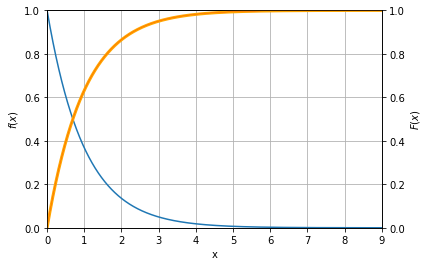

In [41]:
x_max = 9
x = np.linspace(0, x_max, 9000)

f = lambda x : np.exp(-x)
F = lambda x: 1 - np.exp(-x)
F_inv = lambda x : -np.log(1 - x)

delta = x[1] - x[0]
F_emp = delta * np.cumsum(f(x))
F_emp.shape

fig, ax1 = plt.subplots() 
plt.plot(x, f(x))
plt.ylabel('$f(x)$')
plt.xlabel('x')
plt.xlim([0, x_max])
plt.ylim([0, 1])
plt.grid()
ax2 = ax1.twinx()
ax2.plot(x, F(x), color='orange', lw=3)
ax2.set_ylabel('$F(x)$')
ax2.set_xlim([0, x_max])
ax2.set_ylim([0, 1])
ax2.plot(x, F_emp, color='red', lw=0.2)

In [118]:
def plot_hist(samples):
    plt.figure()
    hist = plt.hist(samples, bins=100, density=True, color='orange', edgecolor='white')  
    plt.plot(hist[1], f(hist[1]), color='red', lw=2)
    plt.xlim([0, x_max])
    plt.ylim([0, 1])
    plt.grid()

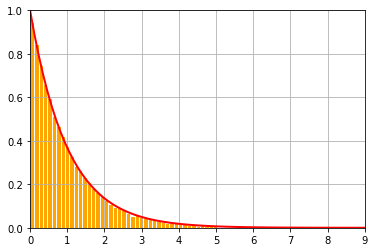

In [169]:
rnd = np.random.uniform(0, 1, 100_000)
samples = F_inv(rnd)
plot_hist(samples)

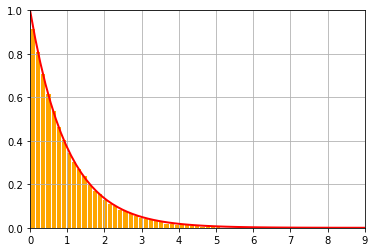

In [170]:
samples = []
for itt in range(100_000):
    rnd = np.random.uniform()
    samples.append(F_inv(rnd))

plot_hist(samples)

In [77]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

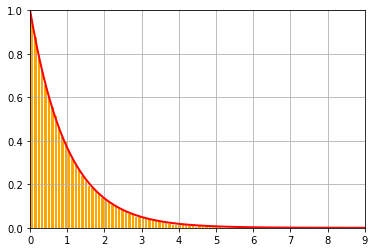

In [171]:
samples = []
for itt in range(100_000):
    rnd = np.random.uniform()
    idx = find_nearest(F(x), rnd)
    samples.append(x[idx])

plot_hist(samples)

In [116]:
def sample_distribution(distrubution, nsamples):
    randvals = np.random.random(nsamples).reshape(-1, 1)    
    return np.argmax(randvals < distribution.cumsum(), axis=1)

Index 0: 0.4500588941105889
Index 1: 0.34987581241875815
Index 2: 0.20006529347065294
Samples average: 0.750006399360064


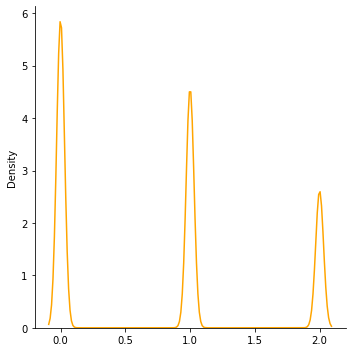

In [132]:
distribution = np.array([0.45, 0.35, 0.2])
samples = sample_distribution(distribution, 1_000_1000)

for i in range(len(distribution)):
    print('Index {}: {}'.format(i, np.mean(samples == i)))
print('Samples average: {}'.format(samples.mean()))

sns.displot(samples, kind='kde', color='orange')

# Accept-reject sampling

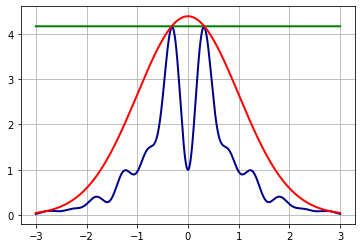

In [10]:
num_grids = 10000
x = np.linspace(-3, 3, 6 * num_grids)
f = lambda x : np.exp(-x ** 2 / 2) * (np.square(np.sin(6 * x)) + 3 * np.square(np.cos(x)) * np.square(np.sin(4 * x)) + 1)
g1 = np.vectorize(lambda x : 1/6)
g2 = lambda x: stats.norm(loc=0, scale=1).pdf(x)

C1 = 25
C2 = 11

plt.plot(x, f(x), color='darkblue', lw=2)
plt.plot(x, C1 * g1(x), color='green', lw=2)
plt.plot(x, C2 * g2(x), color='red', lw=2)
plt.grid()


In [11]:
delta = x[1] - x[0]
area = delta * np.sum(f(x))
print(area)

5.879613782199517


In [87]:
def plot_hist(samples, area):
    plt.figure()
    hist = plt.hist(samples, bins=100, density=True, color='orange', edgecolor='white')  
    plt.plot(hist[1], f(hist[1]) / area, color='red', lw=2)
    plt.grid()

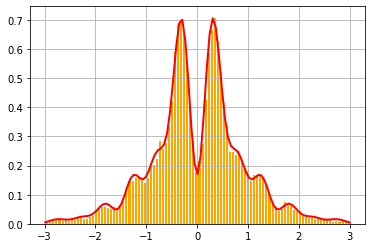

In [13]:
itts = 100000
samples = []

for itt in range(itts):
    x = np.random.uniform(-3, 3)
    u = np.random.uniform(0, C1 * g1(x))
    
    if u < f(x):
        samples.append(x)
    
plot_hist(samples, area)

In [14]:
def acc_rej_sampler(gaussian, C, itts=100_000):
    if gaussian:
        x = np.random.randn(itts)
        u = np.random.uniform(0, C * g2(x))
    else:
        x = np.random.uniform(-3, 3, itts)
        u = np.random.uniform(0, C * g1(x))

    samples = x[u < f(x)]
    return samples

In [15]:
samples_gauss = acc_rej_sampler(True, C1)
samples_unif = acc_rej_sampler(True, C2)

In [16]:
print('acceptance rate for uniform proposal function: {}%'.format(100 * len(samples_unif) / itts))
print('acceptance rate for normal proposal function: {}%'.format(100 * len(samples_gauss) / itts))

acceptance rate for uniform proposal function: 53.839%
acceptance rate for normal proposal function: 23.55%


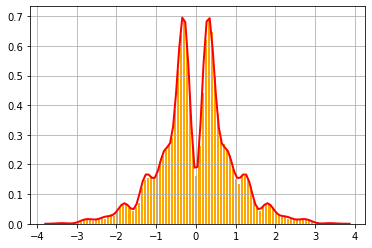

In [17]:
plot_hist(samples_unif, area)

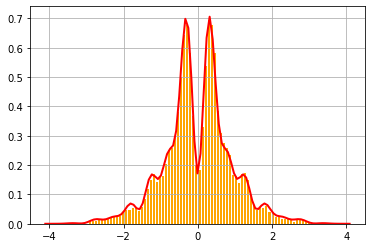

In [18]:
plot_hist(samples_gauss, area)

In [83]:
def plot_corr(samples):
    plt.figure()
    plt.scatter(samples[:-1], samples[1:], s=1)
    plt.xlabel('Previous Sample', fontsize=16)
    plt.ylabel('Current Sample', fontsize=16)
    corr = round(stats.pearsonr(samples[:-1], samples[1:])[0], 2)
    plt.title('Correlation: {}'.format(corr, fontsize=20))

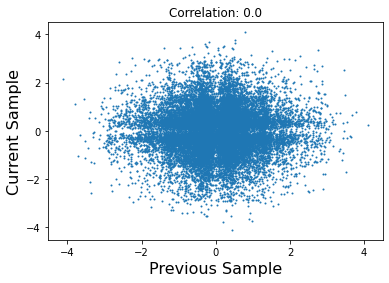

In [66]:
plot_corr(samples_gauss)

# MCMC sampling: Metropolis

In [113]:
def metroplois_sampler(gaussian=True, scale=1, itts=1_000_000):
    samples = [0]
    num_accept = 0
    for itt in range(itts - 1):
        curr = samples[-1]
        if gaussian:
            x = np.random.normal(loc=curr, scale=scale)
        else:
            x = np.random.uniform(-3, 3)
        ratio = f(x) / f(curr)
        #probability of accepting this candidate
        prob = min(1, ratio)
        if np.random.random() <= prob:
            samples.append(x)
            num_accept += 1
        else:
            samples.append(curr)
    return samples, num_accept

In [77]:
starttime = timeit.default_timer()       
samples_normal, num_accept_normal = metroplois_sampler()
print("The time difference is : {} sec".format(timeit.default_timer() - starttime))        

starttime = timeit.default_timer()       
samples_uniform, num_accept_uniform = metroplois_sampler(False)
print("The time difference is : {} sec".format(timeit.default_timer() - starttime))        

The time difference is : 19.475010811001994 sec
The time difference is : 19.06368514399219 sec


In [79]:
burn_in = int(itts / 100)
kept_samples_normal = samples_normal[burn_in:]
kept_samples_uniform = samples_uniform[burn_in:]

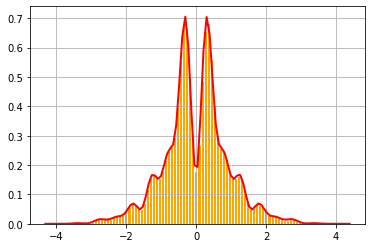

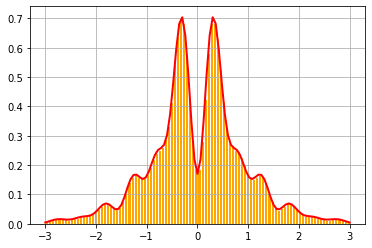

In [88]:
plot_hist(kept_samples_normal, area)
plot_hist(kept_samples_uniform, area)

In [89]:
print('acceptance rate for normal proposal function: {}%'.format(100 * num_accept_normal / len(kept_samples_normal)))
print('acceptance rate for uniform proposal function: {}%'.format(100 * num_accept_uniform / len(kept_samples_uniform)))

acceptance rate for normal proposal function: 59.11501501501502%
acceptance rate for uniform proposal function: 43.177877877877876%


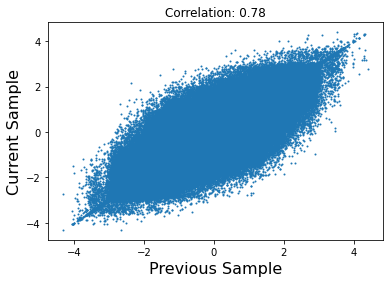

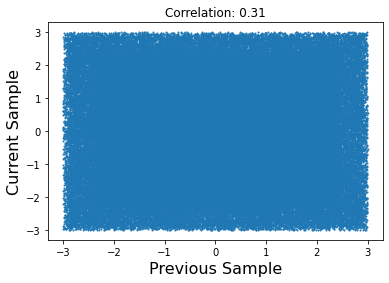

In [84]:
plot_corr(kept_samples_normal)
plot_corr(kept_samples_uniform)

### MCMC: [Another example](https://gist.github.com/ColCarroll/f6985375d3029c0651a4f41e83f99499)

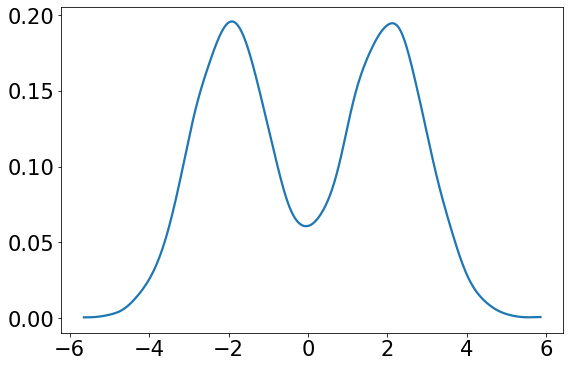

In [2]:
FIGSIZE = (9, 6)

class MixtureOfGaussians:
    """Two standard normal distributions, centered at +2 and -2."""
    def __init__(self):
        self.components = [stats.norm(-2, 1), stats.norm(2, 1)]
        self.weights = np.array([0.5, 0.5])
    
    def pdf(self, x):
        return self.weights.dot([component.pdf(x) for component in self.components])
    
    def rvs(self, size=1):
        idxs = np.random.randint(0, 2, size=size)
        result = np.empty(size)
        for idx, component in enumerate(self.components):
            spots, = np.where(idxs==idx)
            result[spots] = component.rvs(size=spots.shape[0])
        return result
    
az.plot_kde(MixtureOfGaussians().rvs(10_000), figsize=FIGSIZE);

In [3]:
def metropolis_sample(pdf, *, steps, step_size, init=0.):
    """Metropolis sampler with a normal proposal."""
    point = init
    samples = []
    for _ in range(steps):
        proposed = stats.norm(point, step_size).rvs()
        if np.random.rand() < pdf(proposed) / pdf(point):
            point = proposed
        samples.append(point)
    return np.array(samples)

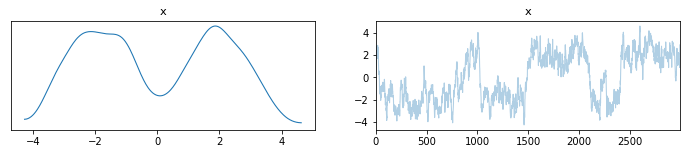

In [29]:
seed = 0
np.random.seed(seed)
samples = metropolis_sample(MixtureOfGaussians().pdf, steps=3_000, step_size=0.4)
az.plot_trace(samples);

## Falling Animation

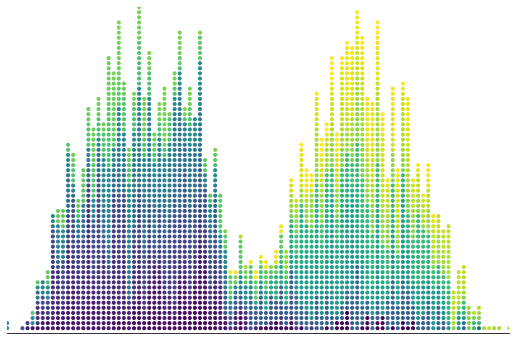

In [31]:
hi, lo = samples.max(), samples.min()
# bins values
x = np.linspace(lo, hi, 100)
#  indices of the bins to which each value in samples array belongs
bins = np.digitize(samples, x, right=True)

counter = np.zeros_like(bins)  # y values
counts = np.zeros_like(x)      # keep track of how points are already in each bin
for idx, bin_ in enumerate(bins):
    counts[bin_] += 1
    counter[idx] = counts[bin_]
counter = counter / counter.max()


# Mess with plot styles here, since it is cheaper than animating
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_ylim(0, 1)
ax.set_xlim(bins.min(), bins.max())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.get_yaxis().set_visible(False)
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, bins.shape[0]))


ax.scatter(bins, counter, marker='.', facecolors=colors);

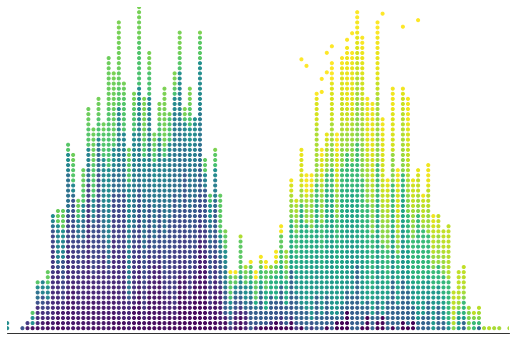

In [32]:
fig, ax = plt.subplots(figsize=FIGSIZE)
xdata, ydata = [], []
ln = ax.scatter([], [], marker='.', animated=True)
cmap = plt.get_cmap('viridis')

def init():
    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.get_yaxis().set_visible(False)
    return ln,

def update(idx):
    xdata.append(bins[idx])
    ydata.append(counter[idx])
    colors = cmap(np.linspace(0, 1, len(xdata)))
    offset = (np.arange(idx + 1) - idx + 49) / 50
    #offset = np.zeros_like(idx + 1) 
    y = np.maximum(ydata, offset)
    ln.set_offsets(np.array([xdata, y]).T)
    ln.set_facecolors(colors)
    return ln, 

anim = FuncAnimation(fig, update, frames=np.arange(bins.shape[0]),
                     init_func=init, blit=True, interval=20)
HTML(anim.to_html5_video())


## Fire hose animation

In [33]:
class Point:
    def __init__(self, x, y, steps=50):
        self.x = x
        self.y = y
        self.v_x = x
        self.v_y = y + 0.5
        self.step = 0
        self.steps = steps
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.step == self.steps:
            return self.x, self.y
        t = self.step / self.steps
        x = self.v_x * t
        y = -0.5 * t * t + self.v_y * t
        self.step += 1
        return x, y

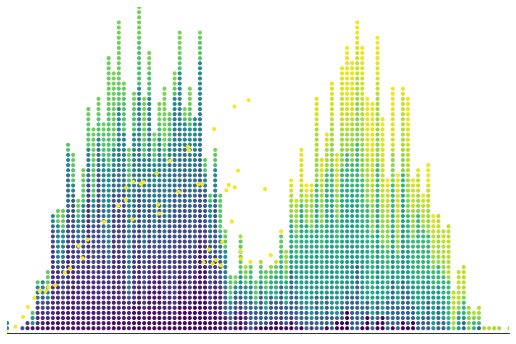

In [34]:
fig, ax = plt.subplots(figsize=FIGSIZE)
xdata, ydata = [], []
ln = ax.scatter([], [], marker='.', animated=True)
cmap = plt.get_cmap('viridis')
points = []

def init():
    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.get_yaxis().set_visible(False)
    return ln,

def update(idx):
    points.append(Point(bins[idx], counter[idx]))
    colors = cmap(np.linspace(0, 1, len(points)))
    ln.set_offsets(np.array([next(p) for p in points]))
    ln.set_facecolors(colors)
    return ln, 

anim = FuncAnimation(fig, update, frames=np.arange(bins.shape[0]),
                     init_func=init, blit=True, interval=20)
HTML(anim.to_html5_video())


## MCMC: Gibbs Sampling

In [43]:
samples_gt = np.random.multivariate_normal([0,0], [[1, 0.5], [0.5,1]], 10000)

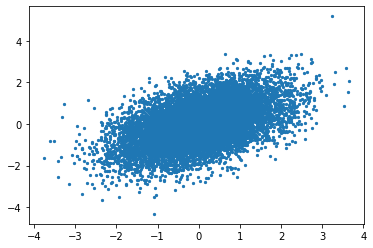

In [44]:
plt.scatter(samples_gt[:,0], samples_gt[:,1], s=5)

#### Marginal pdfs: 

$p(x|y)=\mathcal{N}(\rho y, 1 - \rho^2)$

$p(y|x)=\mathcal{N}(\rho x, 1 - \rho^2)$

In [41]:
num_samples = 10_000
rho = 0.5
samples = {'x': [1], 'y':[-1]}

for _ in range(num_samples):
    y_curr = samples['y'][-1]
    x_new = np.random.normal(rho * y_curr, 1 - rho * rho)
    y_new = np.random.normal(rho * x_new, 1 - rho * rho)
    samples['x'].append(x_new)
    samples['y'].append(y_new)

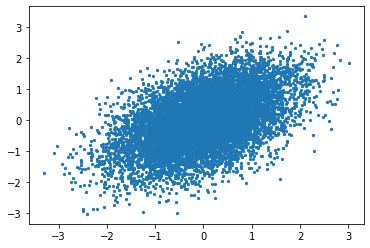

In [42]:
plt.scatter(samples['x'], samples['y'], s=5)

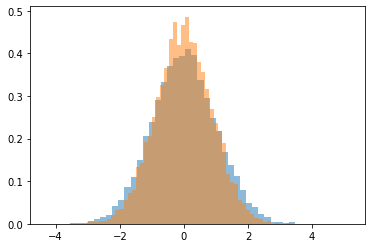

In [46]:
h1 = plt.hist(samples_gt[:,1], bins=50, density=True, alpha=0.5)
h2 = plt.hist(samples['y'], bins=50, density=True, alpha=0.5)

0.0005350045529508337


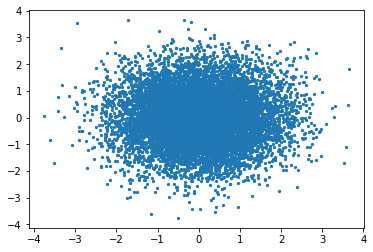

In [49]:
plt.scatter(samples_gt[:-1, 0], samples_gt[1:, 0], s=5)
print(stats.pearsonr(samples_gt[:-1, 0], samples_gt[1:, 0])[0])

0.2459456581017934


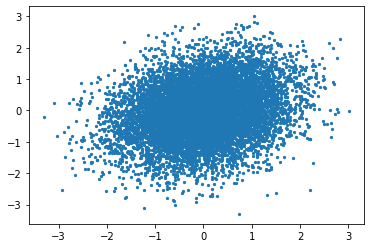

In [51]:
plt.scatter(samples['x'][:-1], samples['x'][1:], s=5)
print(stats.pearsonr(samples['x'][:-1], samples['x'][1:])[0])

### Thompson sampling
* Satisfaction distribution for a restaurant is $\mathcal{N}(\mu, \sigma^2)$
* $\sigma$ of staisfaction districution is known
* We want to find $mu$ of the best restaurant

#### [Posterior pdf](https://en.m.wikipedia.org/wiki/Conjugate_prior)
$\mathcal{N}(\mu_p, \sigma_p)$ where

$\mu_p=\frac{1}{\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}}\left(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^{n}x_i}{\sigma^2}\right)$

$
\sigma_p^2=\left(\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}\right)^{-1}
$


In [126]:
class Restaurant():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def visit(self):
        s = np.random.normal(self.mu, self.sigma)
        self.num_of_visits += 1
        self.total_satisfaction += s
        return s

In [133]:
class ThompsonSampler(Restaurant):
    def __init__(self, mu, sigma):
        # mean of mu
        self.prior_mean = 0
        # std of mu
        self.prior_std = 1000
        self.posterior_mean = self.prior_mean
        self.posterior_std = self.prior_std

        self.num_of_visits = 0
        self.total_satisfaction = 0

        super().__init__(mu, sigma)
        
    def update(self):
        self.posterior_std = np.sqrt(1 / (1 / self.prior_std ** 2 + 
                                  self.num_of_visits / self.sigma ** 2))
        self.posterior_mean = (self.posterior_std ** 2) * (self.prior_mean / self.prior_std ** 2 +
                                                   self.total_satisfaction / self.sigma ** 2)
        
        self.prior_mean = self.posterior_mean
        self.prior_std = self.posterior_std
    
    def sample_mean(self):
        return np.random.normal(self.posterior_mean, self.posterior_std)

In [134]:
def plot_pdf(thompson_samplers, itt):
    xmin = -10
    xmax = 10
    plt.figure()
    for smplr in thompson_samplers:
        samps = np.random.normal(smplr.posterior_mean, smplr.posterior_std, 10_000)
        sns.kdeplot(samps, shade=True)
        #x = np.linspace(xmin, xmax, 10_000)
        #y = stats.norm.pdf(x, smplr.posterior_mean, smplr.posterior_std) 
        #plt.plot(x, y)
        # Shade the area between y and line y=0
        #plt.fill_between(x, y, 0,
        #         facecolor="orange", # The fill color
        #         color='blue',       # The outline color
        #         alpha=0.2)          # Transparency of the fill  
    plt.title('Iteration {}'.format(itt + 1), fontsize=20)
    plt.legend(['mu={}'.format(ts.mu) for ts in thompson_samplers], fontsize=16)
    plt.xlim(xmin, xmax)
    plt.xlabel('Average Satisfacton', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.show()

In [135]:
num_restaurants = 3
spacing = 1
thompson_samplers = [ThompsonSampler(i * spacing, 1) for i in range(1, num_restaurants + 1)]

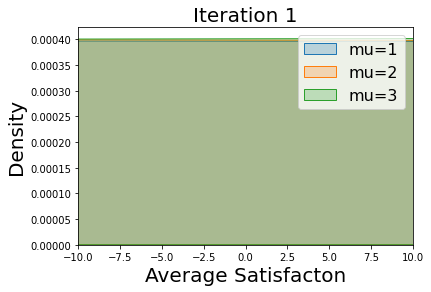

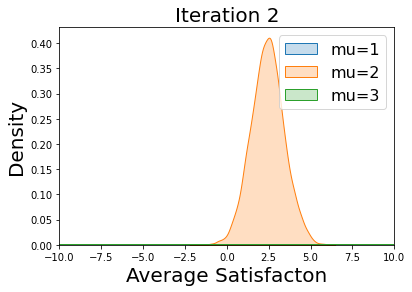

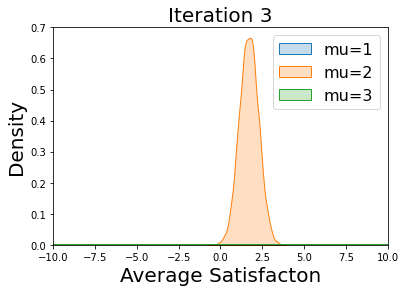

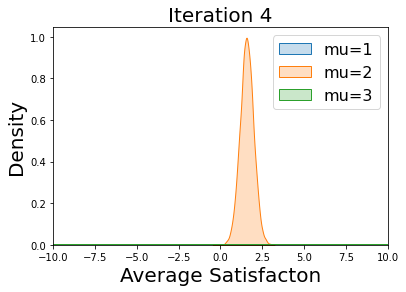

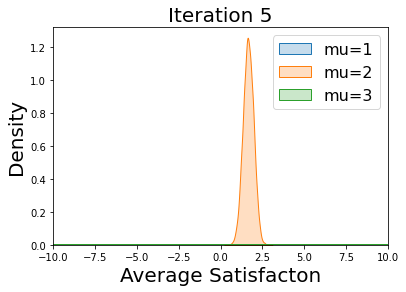

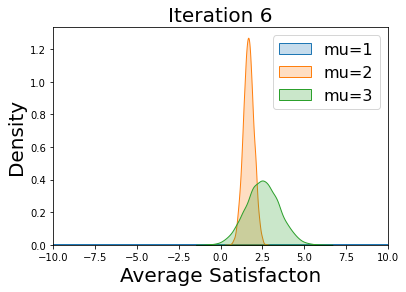

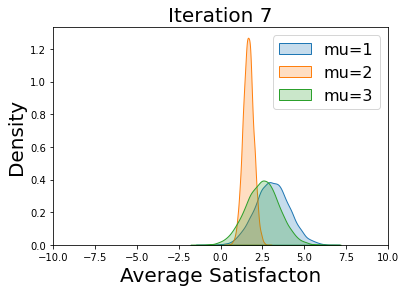

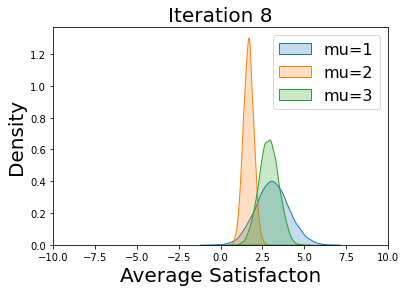

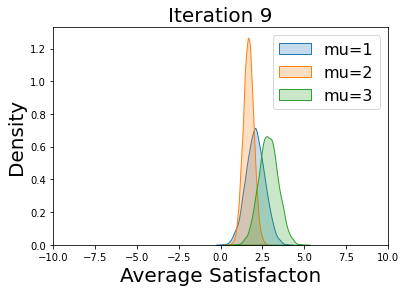

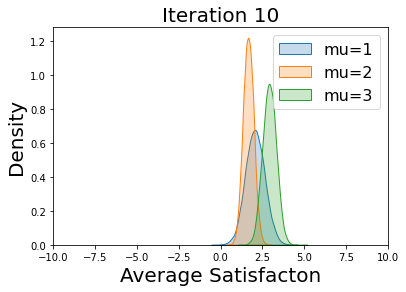

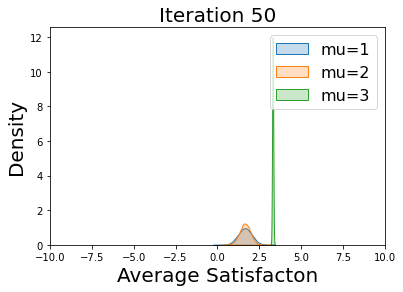

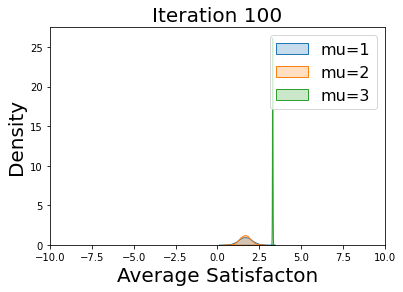

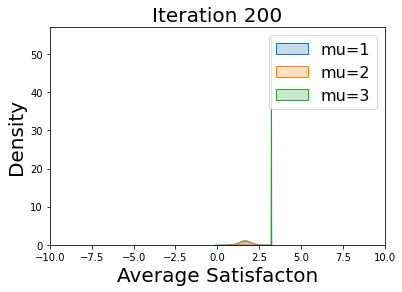

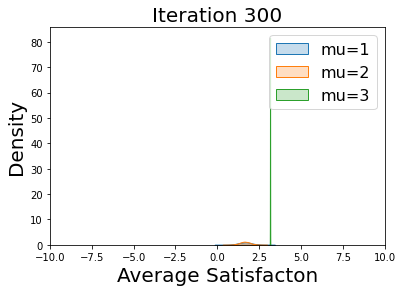

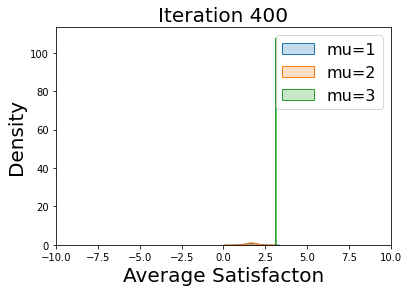

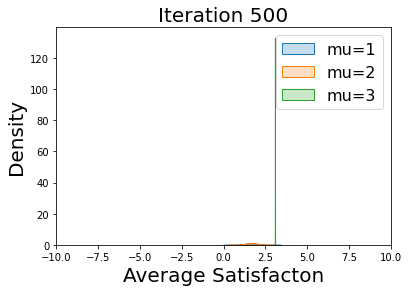

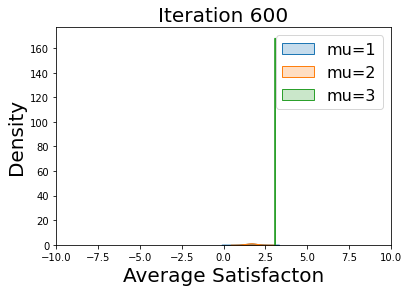

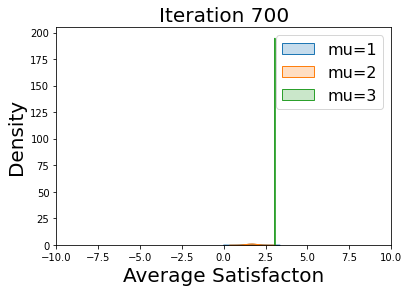

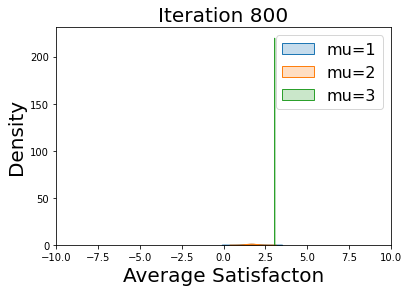

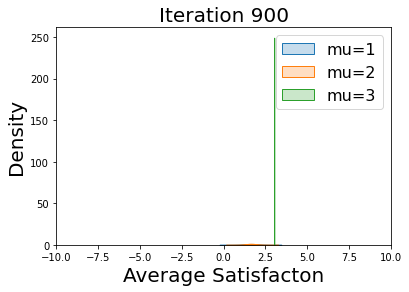

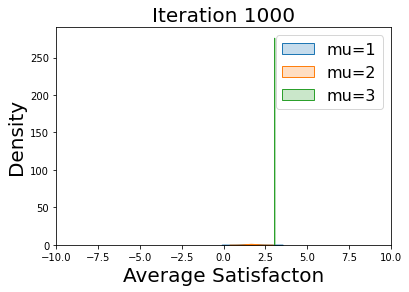

In [136]:
for itt in range(1_000):
    if num_restaurants <= 10 and (itt < 10 or (itt < 100 and (itt + 1) % 50 == 0) or ((itt + 1) % 100 == 0)):
        plot_pdf(thompson_samplers, itt)
    
    # get a sample from each posterior
    mean_samples = [smplr.sample_mean() for smplr in thompson_samplers]
    
    # index of distribution with highest satisfaction
    chosen_idx = mean_samples.index(max(mean_samples))
      
    # get a new sample from the real distribution (visit the restaurant)
    s = thompson_samplers[chosen_idx].visit()
    
    # update that distributions posterior
    thompson_samplers[chosen_idx].update()

[1.6500819277215257, 1.6470087766240267, 3.0215181036248415]
[0.4082482564431764, 0.31622775020545085, 0.0014234662722386426]


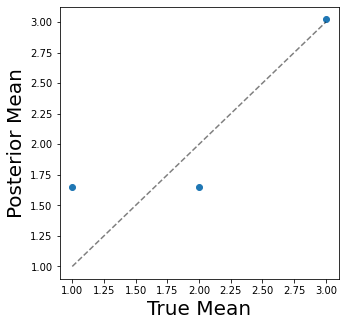

In [137]:
plt.figure(figsize=(5, 5))
true_means = [ts.mu for ts in thompson_samplers]
posterior_means = [ts.posterior_mean for ts in thompson_samplers]
posterior_stds = [ts.posterior_std for ts in thompson_samplers]
plt.scatter(true_means, posterior_means)
plt.plot(true_means, true_means, color='k', alpha=0.5, linestyle='--')
plt.xlabel('True Mean', fontsize=20)
plt.ylabel('Posterior Mean', fontsize=20)

print(posterior_means)
print(posterior_stds)